# Latency and Capacity Estimation For a Network Connection From Asymmetric Measurements

What we are interested in here is the mean time required for sending a message of a given length.
A simple and frequently used model for the performance of a network connection consists of assuming that the time 
T required for sending a message depends mainly on its size S (number of bytes) and two quantities that characterize 
the connection: the latency L (in seconds) and the capacity C (in bytes/second). The relation between these four 
quantities is T(S) = L + S/C. This model neglects a large number of details. L and C certainly depend on the chosen communication protocol, but also to some extent on S. Moreover, a measurement of T(S) includes a strong random  component. What we are interested in here is the mean time required for sending a message of a given length.


## Tasks

** Our task is to estimate L and C from a series of observations of T or different values of S. **

1. Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, if useful at different moments in time and/or on different time scales, in order to evaluate the temporal stability of the phenomenon. Can the variations be explained solely by message size?


2. Plot the transmission time as a function of message size. You should observe a "disruption",  a size starting from which the variability changes qualitatively. Estimate this time graphically, in order to treat the two classes of message size separately.


3. Perform a linear regression for each class and estimate the corresponding values of L and C. Superpose the result of this regression onto the preceding plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

### Task 1
Start by working on the first dataset (liglab2). Plot the time evolution of transmission time, if useful at different moments in time and/or on different time scales, in order to evaluate the temporal stability of the phenomenon. Can the variations be explained solely by message size?

In [2]:
file = open('liglab2.log','r')
# To analyse the file stackoverflow.log uncomment the line below and comment the first one.
# file = open('stackoverflow.log','r') 

Let's start reading the input file "liglab2.log" and taking the values we need.

The file contains many lines like :
> [1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

First, we need to check how many lines does not contais the full information, in other words, to identify and count the packages that was not received.

In [3]:
invalidLines = 0
validLines = 0
for lines in file:
    values = lines.split()
    if(len(values) < 10): #10 is the size of a full row
        invalidLines += 1
    else:
        validLines += 1 
print("Total valid lines: " + str(validLines))
print("Total invalid lines: " + str(invalidLines))

Total valid lines: 44036
Total invalid lines: 377


Considering only the full lines :
> [1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms

We can get the information:

- Size of the packages : value[1] from the lines, ex: 665 bytes
- Time of receive the messages: values[8] fro the lines, ex: time=22.5 ms


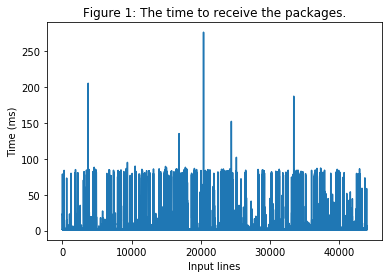

In [4]:
file = open('liglab2.log','r')
times = []
sizes = []
pairs = []
for lines in file:
    values = lines.split()
    if(len(values) == 10):
        times.append(float(values[8].split('=')[1]))
        sizes.append(float(values[1]))
        pairs.append((float(values[1]) ,float(values[8].split('=')[1])))
plt.ylabel('Time (ms)')
plt.xlabel('Input lines')
plt.title("Figure 1: The time to receive the packages.")
plt.plot(times)

#### Conclusion
We can not explain the variation of the time solely by messages size. Analysing the *Figure 1* we can observe some points with bigger or lower values, but we can observe an uniform behavior around the interval (0, 100) s.

### Task 2
Plot the transmission time as a function of message size. You should observe a "disruption",  a size starting from which the variability changes qualitatively. Estimate this time graphically, in order to treat the two classes of message size separately.

To plot *sizes of the messages x time* we need to order the size of the messages, without lose the relation between it and the time of each size.

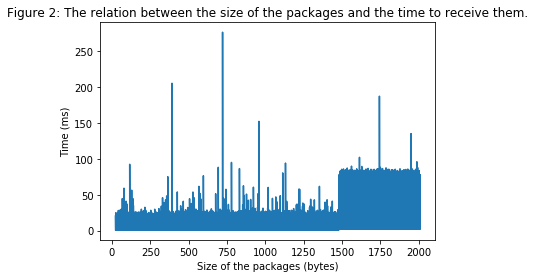

In [5]:
orderedPairs = sorted(pairs)
opX = [] #orderedPair[0]
opY = [] #orderedPair[1]
for x in orderedPairs:
    opX.append((x[0]))
    opY.append((x[1]))
plt.ylabel('Time (ms)')
plt.xlabel('Size of the packages (bytes)')
plt.title("Figure 2: The relation between the size of the packages and the time to receive them.")
plt.plot(opX,opY)

#### Conclusion
We can observe a concentration in the y axis between (0, 50) s, for the values of sizes between (0, 1500) bytes.
We can also observe a "disruption" starting around the packages with size *1500 bytes*. From this changes the behavior of the reception changed as well. We can observe now a concentration between (0, 100) s.
This way, we can separete two kinds of message sizes. The first one with sizes between (0, 1500) bytes, and the second one between (1500, 200) bytes. 

### Task 3


To performe the linear regression, we followed this steps:

Assuming our equation as the model y = mx+c, where m is the coefficient of independent variable and c is the intercept.

The mathematical formula to calculate **slope(m)** is:
> m = (mean(x) * mean(y) – mean(x*y)) / ( mean (x)^2 – mean( x^2))

The formula to calculate **intercept(c)** is:
> c = mean(y) – mean(x) * m

In [6]:
def slope_intercept(xval, yval):
    x = np.array(xval)
    y = np.array(yval)
    m = ( ((np.mean(x) * np.mean(y)) - (np.mean(x*y))) / 
          ((np.mean(x) * np.mean(x)) - (np.mean(x*x))) )
    m = round(m, 2)
    b = (np.mean(y) - np.mean(x) * m)
    b = round(b, 2)
    return m, b

To apply the method to our equation :
> T(S) = L + S/C , to estimate L and C from a series of observations of T for different values of S.

We will take:
> y = T(S), 
> m = L , 
> x = S , 
> c = 1/C .

In [7]:
m, c = slope_intercept(opX, opY)
c = 1/c
print("The coefficient of independency is: " + str(m))
print("The intercept: " + str(c))

The coefficient of independency is: 0.0
The intercept: 0.19455252918287938


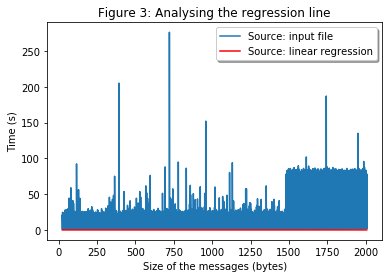

In [8]:
reg_line = [(m * x) + c for x in opX]
plt.plot(opX, opY, label = 'Source: input file')
plt.plot(opX, reg_line, color = "red", label = 'Source: linear regression')
plt.legend(loc = 'upper right', shadow = True)
plt.xlabel("Size of the messages (bytes)")
plt.ylabel("Time (s)")
plt.title("Figure 3: Analysing the regression line")
plt.show()

### Conclusion
We can observe that the regression linear estimated a time of *0.19 s* for all points. This way, we can assume that the time to receive a package does not have a strong dependency between the size of the messages.

*In order to analyse the two groups of the size of the messages, previously created, we can re-caculate and re-plot the data*

**Group A**

The size of the source (piece A): 32000
The coefficient of independency is: 0.0
The intercept value: 0.2849002849002849


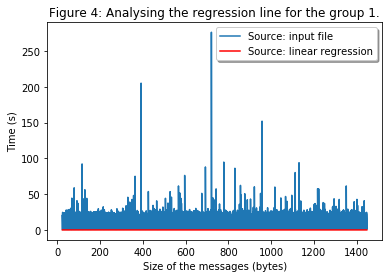

In [9]:
regDataXA = opX[:32000]
regDataYA = opY[:32000]
m, c = slope_intercept(regDataXA, regDataYA)
c = 1/c
print("The size of the source (piece A): " + str(len(regDataXA)))
print("The coefficient of independency is: " + str(m))
print("The intercept value: " + str(c))

reg_lineA = [(m * x) + c for x in regDataXA]
plt.plot(regDataXA, regDataYA, label = 'Source: input file')
plt.plot(regDataXA, reg_lineA, color = "red", label = 'Source: linear regression')
plt.legend(loc = 'upper right', shadow = True)
plt.xlabel("Size of the messages (bytes)")
plt.ylabel("Time (s)")
plt.title("Figure 4: Analysing the regression line for the group 1.")
plt.show()

**Group B**

The coefficient of independency is: 0.01
The intercept value: -0.12755102040816327


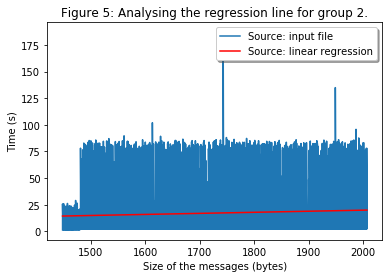

In [10]:
regDataXB = opX[32000:]
regDataYB = opY[32000:]
m, c = slope_intercept(regDataXB, regDataYB)
c = 1/c
print("The coefficient of independency is: " + str(m))
print("The intercept value: " + str(c))

reg_lineB = [(m * x) + c for x in regDataXB]
plt.plot(regDataXB, regDataYB, label = 'Source: input file')
plt.plot(regDataXB, reg_lineB, color = "red", label = 'Source: linear regression')
plt.legend(loc = 'upper right', shadow = True)
plt.xlabel("Size of the messages (bytes)")
plt.ylabel("Time (s)")
plt.title("Figure 5: Analysing the regression line for group 2.")
plt.show()

**Group A + B**

Let's take a look in both (Figure 4 and 5) togheter.

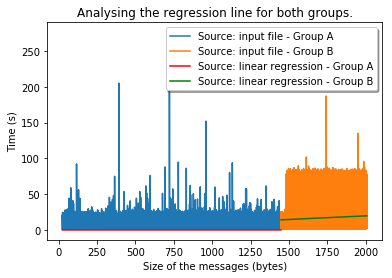

In [11]:
plt.plot(regDataXA, regDataYA, label = 'Source: input file - Group A')
plt.plot(regDataXB, regDataYB, label = 'Source: input file - Group B')
plt.plot(regDataXA, reg_lineA, color = "red", label = 'Source: linear regression - Group A')
plt.plot(regDataXB, reg_lineB, color = "green", label = 'Source: linear regression - Group B')
plt.legend(loc = 'upper right', shadow = True)
plt.xlabel("Size of the messages (bytes)")
plt.ylabel("Time (s)")
plt.title("Analysing the regression line for both groups.")
plt.show()

### Conclusion

We can observe that the linear regression line changed for the second, but does not show us a strong depency as well because it (-0.13) is near from 0.